In [23]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from opformer import TransformerOperator
import kernels
import dataset

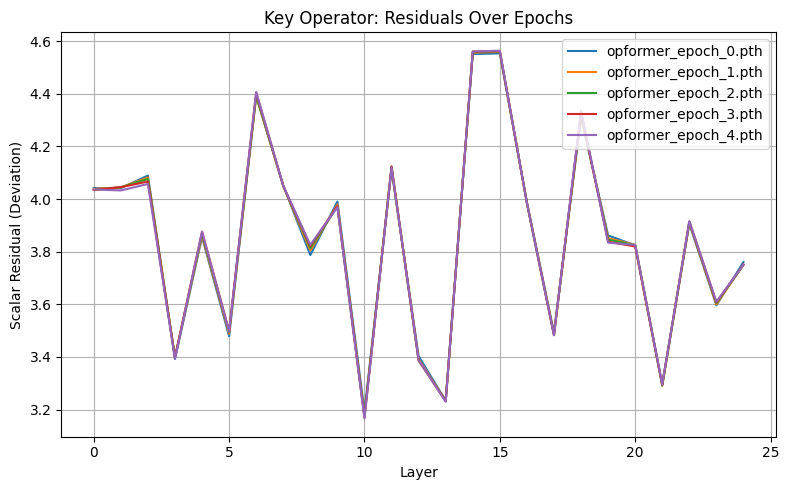

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

H, W = 64, 64  # FFT size

def extract_R_kernels_compact(checkpoint_path, operator_type="key", num_layers=25):
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    Rs = []
    for l in range(num_layers):
        prefix = f"layers.{l}.self_attn.{operator_type}_operator"
        w1 = ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy()
        w2 = ckpt[f"{prefix}.weights2"].squeeze(-1).squeeze().numpy()
        Rs.append((w1, w2))
    return Rs

def check_scalar_identity_approx(R_compact_list):
    scalar_devs = []
    for w1, w2 in R_compact_list:
        diag_w1 = np.diag(w1) if w1.shape[0] == w1.shape[1] else np.diag(w1[:min(w1.shape)])
        diag_w2 = np.diag(w2) if w2.shape[0] == w2.shape[1] else np.diag(w2[:min(w2.shape)])
        all_diag = np.concatenate([diag_w1, diag_w2])
        mean_scalar = np.mean(np.abs(all_diag))
        residual = np.linalg.norm(np.abs(all_diag) - mean_scalar)
        scalar_devs.append((mean_scalar, residual))
    return scalar_devs

def overlay_scalar_residuals(all_devs, operator_type):
    plt.figure(figsize=(8, 5))
    for epoch_label, scalar_devs in all_devs:
        _, residuals = zip(*scalar_devs)
        plt.plot(residuals, label=f"{epoch_label}")

    plt.xlabel("Layer")
    plt.ylabel("Scalar Residual (Deviation)")
    plt.title(f"{operator_type.title()} Operator: Residuals Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_identity_overlay_plot(checkpoint_dir, num_layers=25, max_files=5):
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])[:max_files]

    R_compacts = []
    for operator_type in ["key"]:
        all_devs = []
        for file in checkpoint_files:
            path = os.path.join(checkpoint_dir, file)
            R_compact = extract_R_kernels_compact(path, operator_type, num_layers)
            R_compacts.append(R_compact)
    # return R_compacts
            scalar_devs = check_scalar_identity_approx(R_compact)
            all_devs.append((file, scalar_devs))
        overlay_scalar_residuals(all_devs, operator_type)

# Example usage
run_identity_overlay_plot("checkpoints", num_layers=25, max_files=5)

In [30]:
print(R_compacts[0][0])
print('------------------------------')
print(R_compacts[-1][0])

(array([[-1.1084918 -0.12532367j,  1.3772562 -0.12456056j,
        -0.35790437+1.5636806j , ..., -0.26502723+1.1223494j ,
         0.71814257-0.42565146j,  0.06840833+1.0703528j ],
       [-0.86533314-0.4783897j ,  0.03505183+0.40696532j,
        -0.39729077-0.24502188j, ...,  0.25607008-0.06850901j,
         0.10909881-0.42738625j, -0.06711045+1.1363406j ],
       [-0.6709289 +0.8345174j , -0.2985805 -0.02042987j,
        -0.68139446+0.6688193j , ...,  0.04402984+1.8677603j ,
         0.3183962 +1.2793248j , -0.3426552 -0.7462693j ],
       ...,
       [-0.05383107-0.1544925j , -0.7441814 +0.26995724j,
         0.41433135+0.8697568j , ..., -1.3017566 +1.1249609j ,
        -0.08159429-0.4388388j , -0.1896363 +0.3381735j ],
       [ 0.70353943+0.6389159j ,  1.1952707 -0.34708884j,
         0.13552521+1.5897243j , ...,  0.4793005 -1.0739853j ,
        -0.1389195 -0.39236832j,  0.8679056 -0.01851992j],
       [ 0.983634  -0.78068393j, -0.3678157 +0.21720189j,
        -0.5680049 +0.6196775

/tmp/ipykernel_649024/775127089.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location="cpu")


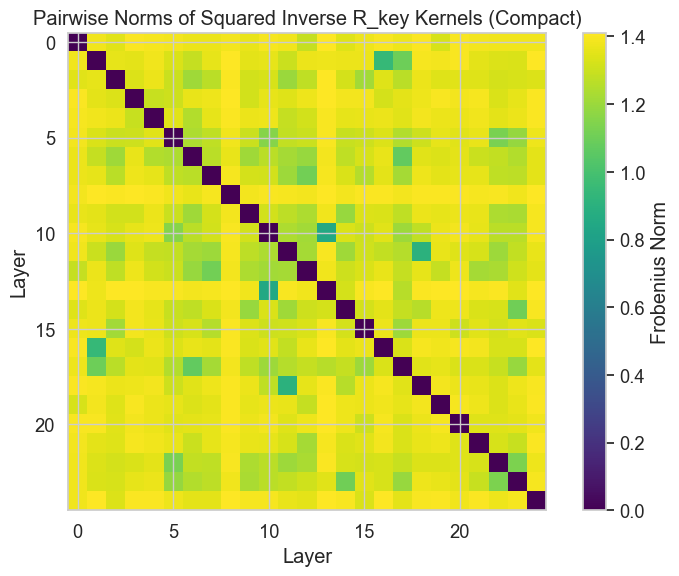

In [68]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

H, W = 64, 64  # FFT size

def extract_R_kernels_compact(checkpoint_path, operator_type="key", num_layers=25):
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    Rs = []
    for l in range(num_layers):
        prefix = f"layers.{l}.self_attn.{operator_type}_operator"
        w1 = ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy()  # shape: (modes1, modes2)
        w2 = ckpt[f"{prefix}.weights2"].squeeze(-1).squeeze().numpy()  # shape: (modes1, modes2)
        # Just keep w1 and w2 individually to avoid unnecessary zero-padding
        Rs.append((w1, w2))
    return Rs

def compute_squared_inverse_compact(R_compact_list):
    Rs_inv_sq = []
    for w1, w2 in R_compact_list:
        inv1 = np.abs(1.0 / (w1 + 1e-8))**2
        inv2 = np.abs(1.0 / (w2 + 1e-8))**2

        # Flatten and normalize
        flat = np.concatenate([inv1.flatten(), inv2.flatten()])
        normed = flat / np.linalg.norm(flat)
        Rs_inv_sq.append(normed)
    return Rs_inv_sq

def plot_pairwise_norm_diffs(vectors, title="Pairwise Frobenius Norm Differences"):
    L = len(vectors)
    norm_diffs = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            norm_diffs[i, j] = np.linalg.norm(vectors[i] - vectors[j])

    plt.figure(figsize=(8, 6))
    plt.imshow(norm_diffs, cmap="viridis")
    plt.colorbar(label="Frobenius Norm")
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()
    return norm_diffs

def run_comparison_plots_compact(checkpoint_path, num_layers=25):
    for operator_type in ["key", "query"]:
        R_compact = extract_R_kernels_compact(checkpoint_path, operator_type, num_layers)
        R_inv_sq = compute_squared_inverse_compact(R_compact)
        title = f"Pairwise Norms of Squared Inverse R_{operator_type} Kernels (Compact)"
        diffs = plot_pairwise_norm_diffs(R_inv_sq, title)
        return diffs

# Example usage
checkpoint_files = sorted([f for f in os.listdir("checkpoints") if f.endswith(".pth")])
pairwise_after = run_comparison_plots_compact(os.path.join("checkpoints", checkpoint_files[0]))  # Replace with latest_ckpt to check post-training

/tmp/ipykernel_649024/775127089.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location="cpu")


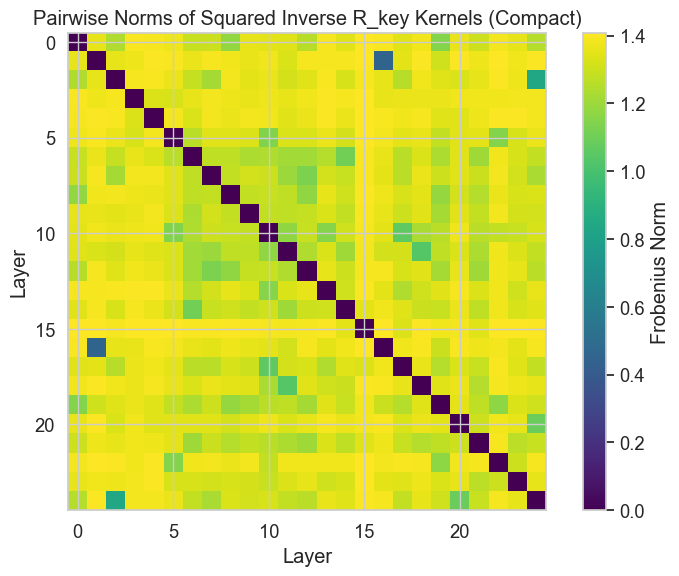

In [69]:
pairwise_before = run_comparison_plots_compact(os.path.join("checkpoints", checkpoint_files[3]))  # Replace with latest_ckpt to check post-training


In [67]:
f"{np.sum(pairwise_before)} vs {np.sum(pairwise_after)}"

'795.0710183978081 vs 795.1100271940231'

In [38]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from opformer import TransformerOperator
import kernels
import dataset

import dataset

H, W = 64, 64
kernel_maps = kernels.Kernels(H, W)

kx_name_true = 'linear'
kx_sigma = 1.0
kx_names = ['linear', 'laplacian', 'gradient_rbf', 'energy']
kx_true = kernels.get_kx_kernel(kx_name_true, sigma=kx_sigma)
ky_true = kernel_maps.get_kernel("gaussian")

num_samples = 25
f, Of = dataset.make_random_operator_dataset(
    kx_true, ky_true, num_samples=num_samples, num_bases=5, seed=0,
)
    
f_test = f[-1]
Of_test = Of[-1]

im_size = (64, 64)
device = "cuda"
Z_test = dataset.construct_Z(f_test, Of, f, im_size, device)

model = TransformerOperator(
    num_layers=5,
    im_size=im_size,
    ky_kernel=ky_true,
    kx_name=kx_name_true,
    kx_sigma=1.0,
    icl_lr=-0.01,
    icl_init=False
).to(device)

model_icl_init = TransformerOperator(
    num_layers=5,
    im_size=im_size,
    ky_kernel=ky_true,
    kx_name=kx_name_true,
    kx_sigma=1.0,
    icl_lr=-0.01,
    icl_init=True
).to(device)

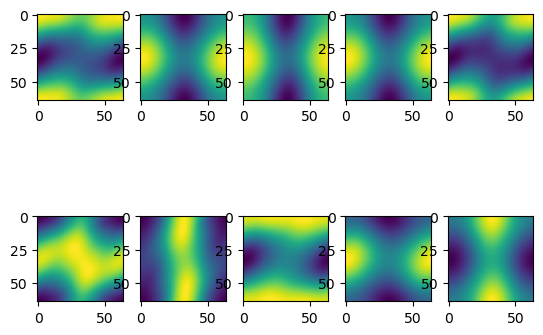

In [39]:
fig, axs = plt.subplots(2, 5)
[  axs[0,i].imshow(Of[i]) for i in range(5)]
[axs[1,i-5].imshow(Of[i]) for i in range(5,10)]

In [30]:
_, _, attns_icl = model_icl_init(Z_test)

attn_norms = []
for epoch in range(0, 500, 10):
    checkpoint = torch.load(f"/home/yppatel/opicl/checkpoints_ddp_sgd/opformer_epoch_{epoch}.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    _, _, attns = model(Z_test)
    attn_norms.append(np.mean(np.linalg.norm(attns[:,0] - attns_icl[:,0], axis=(-2,-1), ord="fro")))

/tmp/ipykernel_1798210/2208002810.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"/home/yppatel/opicl/checkpoints_ddp_sgd/opformer_epoch_{epoch

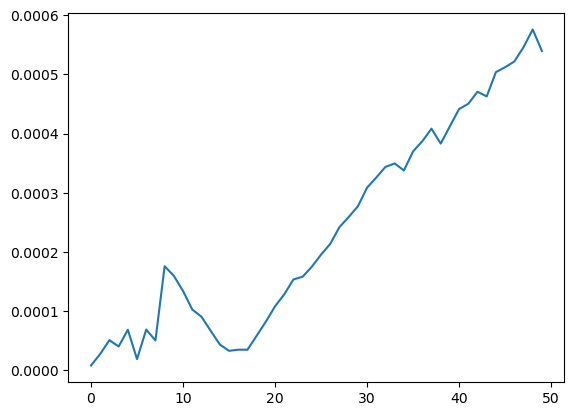

In [31]:
plt.plot(attn_norms)

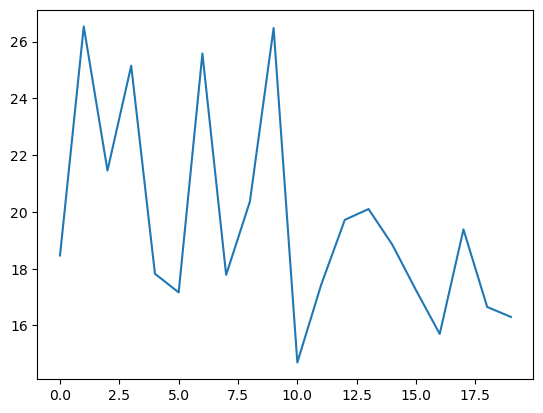

In [32]:
plt.plot([18.467148, 26.534744, 21.458593, 25.152594, 17.822399, 17.164341, 25.581741, 17.783001, 20.362659, 26.479553, 14.696182, 17.423059, 19.722174, 20.102255, 18.850328, 17.244465, 15.700935, 19.384104, 16.651241, 16.300676])

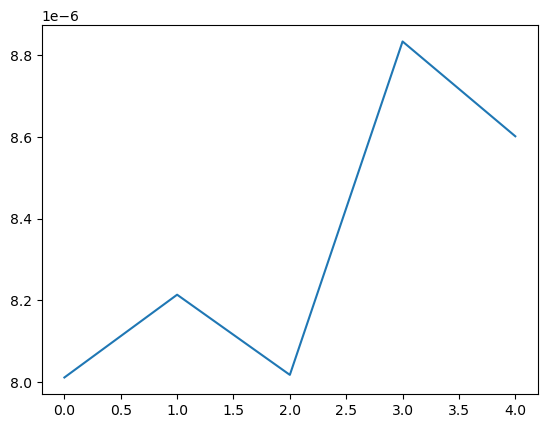

In [29]:
plt.plot(attn_norms)

✅ Loading checkpoint: checkpoints_2/opformer_epoch_0.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_1.pth


/tmp/ipykernel_660295/4099857137.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_file))


✅ Loading checkpoint: checkpoints_2/opformer_epoch_2.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_3.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_4.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_5.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_6.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_7.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_8.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_9.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_10.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_11.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_12.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_13.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_14.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_15.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_16.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_17.pth
✅ Loading checkpoint: checkpoints_2/opformer_epoch_18.pth
✅ Loading checkpoint: 

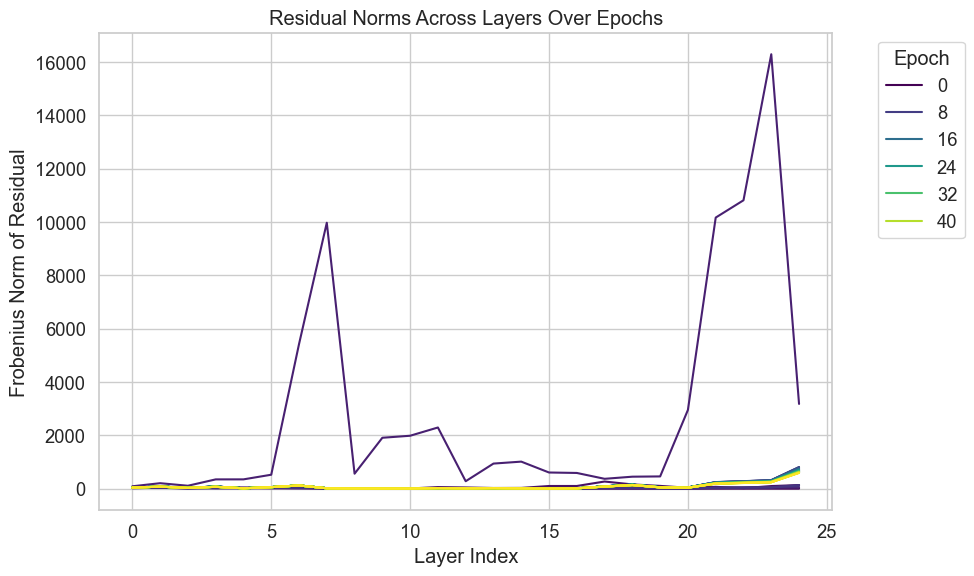

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import re
import glob

sns.set(style="whitegrid", font_scale=1.2)

def load_latest_checkpoint(model, checkpoint_file):
    print(f"✅ Loading checkpoint: {checkpoint_file}")
    model.load_state_dict(torch.load(checkpoint_file))
    model.eval()
    return model

chkpt_errors = []
checkpoint_dir = "checkpoints_2"

# Sort checkpoint files numerically by epoch index
checkpoint_files = sorted(
    glob.glob(os.path.join(checkpoint_dir, "opformer_epoch_*.pth")),
    key=lambda x: int(re.search(r"epoch_(\d+)", x).group(1))
)

# Compute errors per checkpoint
for checkpoint_file in checkpoint_files:
    model = load_latest_checkpoint(model, checkpoint_file)
    pred, preds = model(Z_test)
    final_preds = np.array(preds)[:, 0, -1, 64:, :, 0]
    errors = np.linalg.norm(final_preds + Of_test, axis=(1, 2), ord="fro")
    chkpt_errors.append(errors)

# Convert to long-form DataFrame for seaborn
df = pd.DataFrame(chkpt_errors)  # Skip early epochs if desired
df_long = df.reset_index().melt(id_vars="index", var_name="Layer", value_name="Residual Norm")
df_long.rename(columns={"index": "Epoch"}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Layer", y="Residual Norm", hue="Epoch", palette="viridis")
plt.title("Residual Norms Across Layers Over Epochs")
plt.xlabel("Layer Index")
plt.ylabel("Frobenius Norm of Residual")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

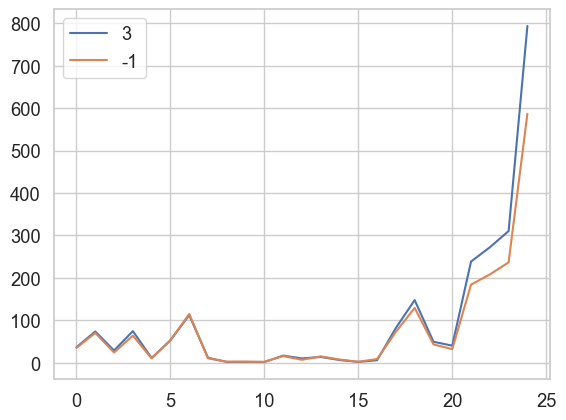

In [76]:
# plt.plot(chkpt_errors[1], label="1")
plt.plot(chkpt_errors[10], label="3")
plt.plot(chkpt_errors[-1], label="-1")
plt.legend()

In [43]:
w1s, w2s = [], []
for checkpoint_file in checkpoint_files:
    ckpt = torch.load(checkpoint_file, map_location="cpu")

    layer_idx = 1
    prefix = f"layers.{layer_idx}.self_attn.key_operator"
    w1 = ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy()  # shape: (H', W')
    w2 = ckpt[f"{prefix}.weights2"].squeeze(-1).squeeze().numpy()
    
    w1s.append(w1)
    w2s.append(w2)

/tmp/ipykernel_649024/2726919163.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location="cpu")


In [46]:
vars = [np.var(np.abs(w1)) for w1 in w1s]

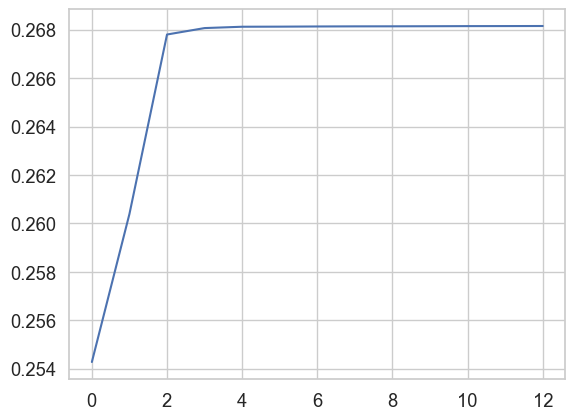

In [47]:
plt.plot(vars)

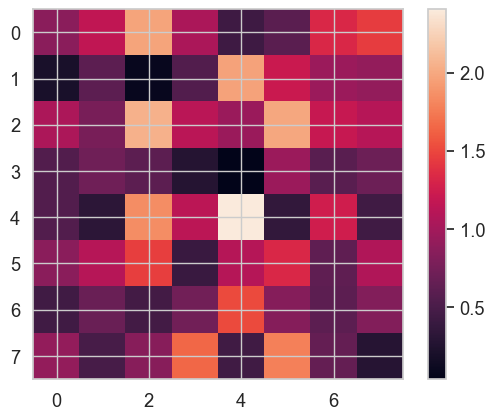

In [32]:
plt.imshow(np.abs(w1s[-1]))
plt.colorbar()

In [13]:
norms = [np.abs(np.mean(np.abs(w1)) - 1) for w1 in w1s]

NameError: name 'w1s' is not defined

In [15]:
plt.plot(w1s[-1])

NameError: name 'w1s' is not defined

In [21]:
np.mean(np.abs(w1s[0]))

np.float32(0.89383054)

In [24]:
import numpy as np
from numpy.fft import ifftn

def GRF(alpha, beta, gamma, N, num_samples=10):
    """
    Generate `num_samples` samples from a Gaussian random field on an NxN grid.

    Parameters:
        alpha (float): scaling coefficient
        beta (float): smoothness constant in spectral decay
        gamma (float): decay exponent
        N (int): spatial resolution (grid size)
        num_samples (int): number of GRF samples to draw

    Returns:
        f_spatials: (num_samples, N, N) real-valued spatial samples
    """
    # Frequency grid
    K1, K2 = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    freq_sq = K1**2 + K2**2
    coef = alpha**0.5 * (4 * np.pi**2 * freq_sq + beta)**(-gamma / 2)  # shape (N, N)

    # Sample iid standard normals for Fourier coefficients
    xi = np.random.randn(num_samples, N, N)  # (B, N, N)

    # Apply coefficient decay and scale
    L = N * coef[None, :, :] * xi  # broadcast (B, N, N)

    # Enforce zero mean in Fourier domain
    L[:, 0, 0] = 0.0

    # Inverse FFT to real-valued spatial domain
    f_spatials = np.real(ifftn(L, norm='forward', axes=(-2, -1)))  # (B, N, N)

    return f_spatials

In [29]:
alpha, beta, gamma, N = 1.0, 1.0, 4.0, 64

num_meta_samples = 10
num_bases = 50
basis_fs = GRF(alpha, beta, gamma, N, num_samples=num_meta_samples * num_bases).reshape(num_meta_samples, num_bases, 64, 64)

In [30]:
basis_fs.shape

(10, 50, 64, 64)

In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from opformer import TransformerOperator, apply_spatial_conv, compute_kx
import kernels
import dataset

In [2]:
num_meta_samples = 10
num_incontext = 25
num_bases = 5
im_size = (64, 64)
device = "cuda"

H, W = im_size
kx = "linear"
kernel_maps = kernels.Kernels(H, W)
ky = kernel_maps.get_kernel("gaussian")

alpha = 1.0
beta = 1.0
gamma = 4.0
N = H
lambda_std = 5.0

In [68]:
import einops

batch_size = 32

# Sample function values
basis_fs = einops.rearrange(
    torch.from_numpy(dataset.GRF(alpha, beta, gamma, N, batch_size * num_bases)).to(torch.float32),
    "(n b) h w -> n b h w", n=batch_size
).unsqueeze(-1)  # (B, B', H, W, 1)

basis_gs = einops.rearrange(
    torch.from_numpy(dataset.GRF(alpha, beta, gamma, N, batch_size * num_bases)).to(torch.float32),
    "(n b) h w -> n b h w", n=batch_size
).unsqueeze(-1)

fs = einops.rearrange(
    torch.from_numpy(dataset.GRF(alpha, beta, gamma, N, batch_size * num_incontext)).to(torch.float32),
    "(n s) h w -> n s h w", n=batch_size
).unsqueeze(-1)  # (B, S, H, W, 1)

# Spatial convolution: (B, B', H, W, 1)
ky_kernel_torch = torch.from_numpy(ky).to(torch.float32).view(1, 1, *ky.shape)
g_convs_torch = apply_spatial_conv(basis_gs, ky_kernel_torch)  # (B, B', H, W, 1)
g_convs = g_convs_torch.squeeze(-1)  # (B, B', H, W)

# Sample λs and apply to g_convs
lambdas = torch.from_numpy(lambda_std * np.random.randn(batch_size, num_bases)).to(torch.float32)  # (B, B')
lambdas = lambdas.unsqueeze(-1).unsqueeze(-1)  # (B, B', 1, 1)
scaled_g_convs = lambdas * g_convs  # (B, B', H, W)

# Compute inner products: (B, S, B')
f_kx = compute_kx(fs, basis_fs, kx_name=kx, kx_sigma=1.0)

# Combine via batched sum: (B, S, H, W)
Ofs = torch.einsum("nbhw,nsb->nshw", scaled_g_convs, f_kx)

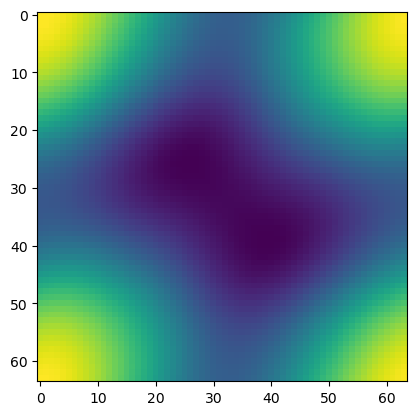

In [69]:
plt.imshow(Ofs[0][0])

In [70]:
import numpy as np
import torch
import einops

from scipy.signal import correlate2d
from dataset import GRF, np_conv  # assumes your helpers are in dataset.py
from opformer import compute_kx, apply_spatial_conv  # your vectorized kernel

def test_vectorized_dataset_generation_equivalence():
    # Parameters
    H, W = 64, 64
    N = H
    alpha, beta, gamma = 1.0, 1.0, 4.0
    num_bases = 8
    num_incontext = 10
    lambda_std = 5.0
    kx_name = "linear"
    kx_sigma = 1.0

    # Generate ky and kx kernels
    from kernels import Kernels, get_kx_kernel
    ky = Kernels(H, W).get_kernel("gaussian", sigma=1.0)
    kx_fn = get_kx_kernel(kx_name, sigma=kx_sigma)

    # === Unbatched version ===
    basis_fs = GRF(alpha, beta, gamma, N, num_bases)
    basis_gs = GRF(alpha, beta, gamma, N, num_bases)
    lambdas = lambda_std * np.random.randn(num_bases)
    g_convs = np.array([np_conv(ky, g) for g in basis_gs])

    fs = GRF(alpha, beta, gamma, N, num_incontext)
    Ofs_ref = np.zeros((num_incontext, H, W))
    for j in range(num_incontext):
        for i in range(num_bases):
            inner = kx_fn(fs[j], basis_fs[i])
            Ofs_ref[j] += lambdas[i] * inner * g_convs[i]

    # === Vectorized version ===
    # Convert everything to torch
    fs_torch       = torch.from_numpy(fs).unsqueeze(0).unsqueeze(-1).to(torch.float32)               # (1, S, H, W, 1)
    basis_fs_torch = torch.from_numpy(basis_fs).unsqueeze(0).unsqueeze(-1).to(torch.float32)         # (1, B, H, W, 1)
    basis_gs_torch = torch.from_numpy(basis_gs).unsqueeze(0).unsqueeze(-1).to(torch.float32)         # (1, B, H, W, 1)

    ky_kernel = torch.from_numpy(ky).to(torch.float32).view(1, 1, H, W)
    g_convs_torch = apply_spatial_conv(basis_gs_torch, ky_kernel)  # (1, B, H, W, 1)
    g_convs = g_convs_torch.squeeze(-1)                            # (1, B, H, W)

    lambdas_torch = torch.from_numpy(lambdas).view(1, num_bases, 1, 1).to(torch.float32)  # (1, B, 1, 1)
    scaled_g_convs = lambdas_torch * g_convs  # (1, B, H, W)

    f_kx = compute_kx(fs_torch, basis_fs_torch, kx_name=kx_name, kx_sigma=kx_sigma)  # (1, S, B)
    Ofs_vec = torch.einsum("nbhw,nsb->nshw", scaled_g_convs, f_kx).squeeze(0)  # (S, H, W)

    # === Compare
    diff = torch.norm(Ofs_vec - torch.from_numpy(Ofs_ref).to(torch.float32))
    print(f"✅ L2 difference between unbatched and vectorized: {diff.item():.3e}")
    assert diff < 1e-4, "Vectorized and unbatched outputs do not match!"

# Run the test
test_vectorized_dataset_generation_equivalence()

✅ L2 difference between unbatched and vectorized: 7.713e-05


In [ ]:
import torch
import numpy as np
from dataset import GRF
from kernels import get_kx_kernel, Kernels
from opformer import apply_spatial_conv, compute_kx  # Adjust import as needed

def test_vectorized_ofs_equivalence():
    H = W = N = 64
    num_bases = 10
    num_incontext = 25
    alpha = beta = 1.0
    gamma = 4.0
    lambda_std = 5.0

    # Generate shared data
    ky = Kernels(H, W).get_kernel("gaussian")
    ky_kernel_torch = torch.from_numpy(ky).to(torch.float32).view(1, 1, H, W)

    basis_fs_np = GRF(alpha, beta, gamma, N, num_bases)
    basis_gs_np = GRF(alpha, beta, gamma, N, num_bases)
    fs_np       = GRF(alpha, beta, gamma, N, num_incontext)
    lambdas_np  = lambda_std * np.random.randn(num_bases)

    # ----- Unbatched version -----
    Ofs_unbatched = np.zeros((num_incontext, H, W))
    kx_func = get_kx_kernel("linear", sigma=1.0)
    g_convs_unbatched = np.array([
        dataset.np_conv(ky, g) for g in basis_gs_np
    ])  # (num_bases, H, W)

    for j in range(num_incontext):
        for i in range(num_bases):
            inner = kx_func(fs_np[j], basis_fs_np[i])
            Ofs_unbatched[j] += lambdas_np[i] * inner * g_convs_unbatched[i]

    # ----- Vectorized version -----
    fs = torch.from_numpy(fs_np).unsqueeze(0).unsqueeze(-1).to(torch.float32)              # (1, T, H, W, 1)
    basis_fs = torch.from_numpy(basis_fs_np).unsqueeze(0).unsqueeze(-1).to(torch.float32)  # (1, B, H, W, 1)
    basis_gs = torch.from_numpy(basis_gs_np).unsqueeze(0).unsqueeze(-1).to(torch.float32)  # (1, B, H, W, 1)

    g_convs_torch = apply_spatial_conv(basis_gs, ky_kernel_torch)  # (1, B, H, W, 1)
    g_convs = g_convs_torch.squeeze(0).squeeze(-1)                 # (B, H, W)

    lambdas = torch.from_numpy(lambdas_np).unsqueeze(-1).unsqueeze(-1).to(torch.float32)  # (B, 1, 1)
    scaled_g_convs = lambdas * g_convs                                                    # (B, H, W)

    f_kx = compute_kx(fs, basis_fs, kx_name="linear", kx_sigma=1.0).squeeze(0)  # (1,T, B)
    Ofs_vectorized = torch.einsum('bhw,tb->thw', scaled_g_convs, f_kx).cpu().numpy()

    # ----- Compare -----
    assert np.allclose(Ofs_vectorized, Ofs_unbatched, atol=1e-4), "❌ Mismatch between vectorized and unbatched Ofs!"
    print("✅ Vectorized and unbatched Ofs match.")

# Run the test
test_vectorized_ofs_equivalence()


✅ Vectorized and unbatched Ofs match.


In [ ]:
kernel_maps = kernels.Kernels(args['im_size'][0], args['im_size'][1])
ky_kernel_arr = kernel_maps.get_kernel(args['ky_kernel_name'])
test_data_gen = MetaOperatorDataset_PreGenerated(
    1, args['kx_name'], ky_kernel_arr, 
    num_incontext_prompts=args['num_incontext_samples_analysis'],
    num_operator_bases=args['num_operator_bases_analysis'],
    im_size=args['im_size'], fixed_operator_seed=args.get('fixed_operator_seed_analysis'),
    fixed_prompts_seed=args.get('fixed_prompts_seed_analysis'))

torch.Size([1, 5, 64, 64])

In [ ]:
from opformer import TransformerOperator 
import matplotlib.pyplot as plt
import kernels 
from dataset_utils import MetaOperatorDataset_PreGenerated # Import from new utils file
import config_setup # Import the new config file

H, W = 64, 64
im_size_config = (H, W)
ky_kernel_name_config = "gaussian"
kx_name_config = 'linear' # Used for ICL-init model and assumed for learned model
num_incontext_samples = 10 # T, for visualizing T x T matrices

kernel_maps_for_test_data = kernels.Kernels(H, W)
ky_true_for_test_data = kernel_maps_for_test_data.get_kernel(ky_kernel_name_config)

# Using MetaOperatorDatasetFixedOperator as it's designed for a single operator
test_data_generator = MetaOperatorDataset_PreGenerated( # Changed class name
    1, 
    kx_name=kx_name_config, 
    ky_kernel_array=ky_true_for_test_data, # Pass the numpy array
    im_size=im_size_config, 
    num_incontext_prompts=3, # Or make configurable
    num_operator_bases=3,     # Or make configurable, e.g. args['num_operator_bases']
)
Z_test_cpu, Of_test = test_data_generator[0] # We only need Z_test for input

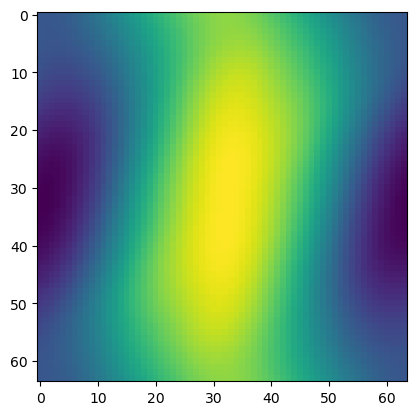

In [9]:
plt.imshow(Of_test)

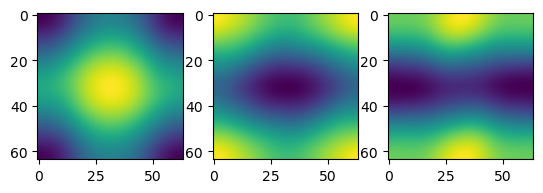

In [10]:
import matplotlib.pyplot as plt

T = 3

fig, axs = plt.subplots(1, T)
for t in range(T):
    axs[t].imshow(Z_test_cpu[t][:64].cpu().numpy())

In [1]:
# analysis_refactored.py
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import pandas as pd
import seaborn as sns

from opformer import TransformerOperator
import kernels 
from dataset_utils import MetaOperatorDataset_PreGenerated # Import from shared utils
import config_setup # Import the new config file

def load_checkpoint_data(checkpoint_path):
    ckpt_data = torch.load(checkpoint_path, map_location="cpu")
    return ckpt_data['model_state_dict'] if isinstance(ckpt_data, dict) and 'model_state_dict' in ckpt_data else ckpt_data

def get_epoch_from_filename(filename):
    match = re.search(r"opformer_epoch_(\d+)\.pth", os.path.basename(filename))
    return int(match.group(1)) if match else -1

def plot_attention_score_matrix(kx_matrix, title, epoch, layer_idx, results_dir):
    if kx_matrix is None: return
    plt.figure(figsize=(8, 7)); plt.imshow(kx_matrix, cmap="viridis", aspect='auto')
    plt.colorbar(label="Similarity Score (kx)"); plt.title(f"{title}\n(E{epoch}, L{layer_idx})", fontsize=14)
    plt.xlabel("Key Idx"); plt.ylabel("Query Idx"); plt.tight_layout()
    os.makedirs(results_dir, exist_ok=True)
    filename = os.path.join(results_dir, f"AttnScores_E{epoch}_L{layer_idx}_{title.replace(' ', '_')}.png")
    plt.savefig(filename); plt.close()

def analyze_checkpoint_kx_scores(checkpoint_path, model_learned, model_icl_init, Z_test_tensor, args):
    epoch = get_epoch_from_filename(checkpoint_path)
    stats = {"epoch": epoch, "avg_kx_diff_norm": np.nan}
    num_layers = args['num_layers_in_model']
    results_dir = args['results_output_directory']
    
    try:
        model_state_dict = load_checkpoint_data(checkpoint_path)
        if model_state_dict is None: raise ValueError("Failed to load model_state_dict")
        model_learned.load_state_dict(model_state_dict); model_learned.eval()
        model_icl_init.eval()

        with torch.no_grad():
            # Assumes model.forward returns: final_pred, zs_outputs, kx_list_numpy
            _, _, learned_attns_kx = model_learned(Z_test_tensor) 
            _, _, icl_init_attns_kx = model_icl_init(Z_test_tensor)
        
        if learned_attns_kx is not None and icl_init_attns_kx is not None and \
           len(learned_attns_kx) == num_layers and len(icl_init_attns_kx) == num_layers:
            kx_diff_norms = [np.linalg.norm(learned_attns_kx[i,0] - icl_init_attns_kx[i,0], ord="fro") / 
                             (np.linalg.norm(icl_init_attns_kx[i,0], ord="fro") + 1e-9) # Relative diff
                             for i in range(num_layers)]
            stats["avg_kx_diff_norm"] = np.mean(kx_diff_norms)

            if args.get('plot_individual_kx_matrices', False) and epoch in args.get('epochs_to_plot_kx_for', []):
                for l_idx in args.get('layers_to_plot_kx_for', []):
                    if 0 <= l_idx < num_layers:
                        plot_attention_score_matrix(learned_attns_kx[l_idx,0], "Learned kx", epoch, l_idx, results_dir)
                        plot_attention_score_matrix(icl_init_attns_kx[l_idx,0], "ICL-init kx", epoch, l_idx, results_dir)
        else:
            print(f"Warn: Could not retrieve kx for E{epoch}.")
    except Exception as e: print(f"Error processing ckpt {os.path.basename(checkpoint_path)} for kx: {e}")
    return stats


In [2]:
args = config_setup.get_analysis_args(experiment_name="adam_small") # Match experiment name

results_dir = args['results_output_directory']
os.makedirs(results_dir, exist_ok=True)
if not os.path.isdir(args['checkpoint_directory']): print(f"Error: Ckpt dir '{args['checkpoint_directory']}' not found."); exit()

print("Generating fixed test sample for kx analysis...")
kernel_maps = kernels.Kernels(args['im_size'][0], args['im_size'][1])
ky_kernel_arr = kernel_maps.get_kernel(args['ky_kernel_name'])
test_data_gen = MetaOperatorDataset_PreGenerated(
    1, args['kx_name'], ky_kernel_arr, 
    num_incontext_prompts=args['num_incontext_samples_analysis'],
    num_operator_bases=args['num_operator_bases_analysis'],
    im_size=args['im_size'], fixed_operator_seed=args.get('fixed_operator_seed_analysis'),
    fixed_prompts_seed=args.get('fixed_prompts_seed_analysis'))
Z_test_cpu_task, _ = test_data_gen[0]
Z_test_tensor = Z_test_cpu_task.unsqueeze(0).to(torch.device(args['analysis_device_str']))

Generating fixed test sample for kx analysis...


In [8]:
Z_test_cpu_task.shape

torch.Size([25, 128, 64])

In [9]:
import matplotlib.pyplot as plt
import torch

def visualize_Z_sample(Z_tensor, save_path=None, num_samples=25, cmap='viridis'):
    """
    Visualize a (T=25, 2H=128, W=64) tensor where each sample is split vertically
    into input (top 64 rows) and output (bottom 64 rows).

    Parameters:
        Z_tensor: torch.Tensor of shape (T, 2H, W)
        save_path: optional filepath to save the plot
        num_samples: number of Z[i] rows to visualize (default 25)
        cmap: matplotlib colormap
    """
    T, H2, W = Z_tensor.shape
    H = H2 // 2
    assert T >= num_samples, f"Z only has {T} samples, but asked for {num_samples}"

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 2 * num_samples))

    for i in range(num_samples):
        z_i = Z_tensor[i]  # shape: (2H, W)
        input_img = z_i[:H].numpy()
        output_img = z_i[H:].numpy()

        axes[i, 0].imshow(input_img, cmap=cmap)
        axes[i, 0].set_title(f"Input f[{i}]"); axes[i, 0].axis("off")

        axes[i, 1].imshow(output_img, cmap=cmap)
        axes[i, 1].set_title(f"Output Of[{i}]"); axes[i, 1].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved Z visualization to: {save_path}")
    plt.show()


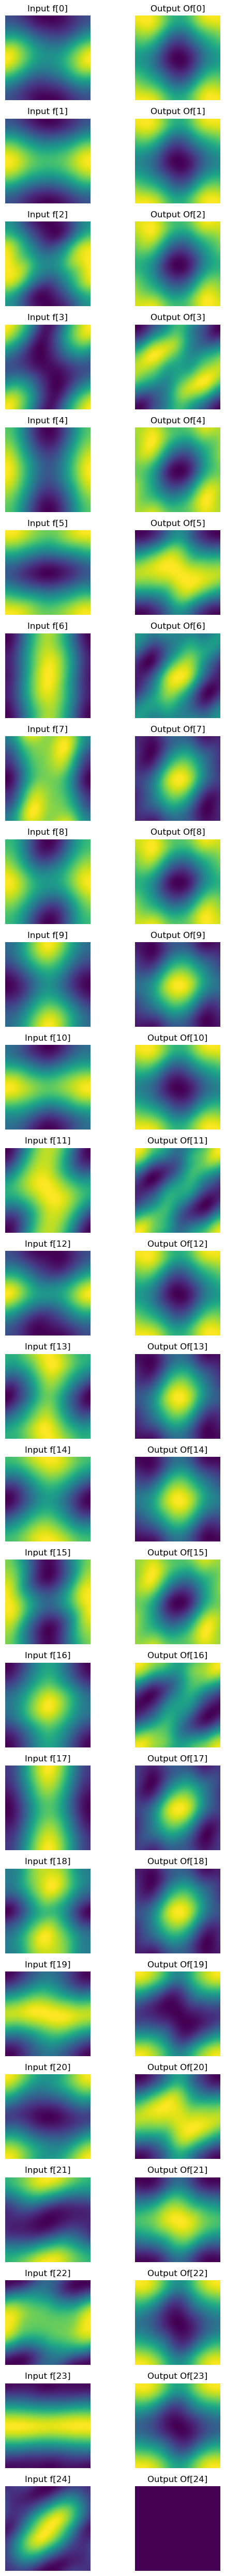

In [10]:
visualize_Z_sample(Z_test_cpu_task)

In [ ]:
def GRF(alpha, beta, gamma, N, num_samples=10):
    xi_ = np.random.randn(num_samples, N, N) * 
    xi  = np.zeros(xi_.shape)
    xi[:4,:4] = xi_[:4,:4]

    K1, K2 = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    freq_sq = (K1**2 + K2**2)
    coef = alpha**0.5 * (4*np.pi**2 * freq_sq + beta)**(-gamma/2)
    L = N * coef * xi
    L[:, 0, 0] = 0  # enforce mean 0
    f_spatials = np.real(ifftn(L, norm='forward', axes=(-2, -1)))
    return f_spatials


In [65]:
import numpy as np
from numpy.fft import fftn, ifftn
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

fs = GRF(1000,10,4,64,10)

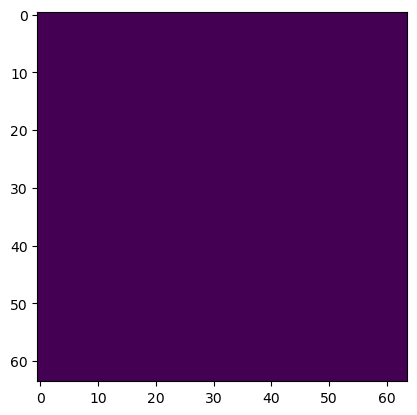

In [66]:
plt.imshow(fs[0])

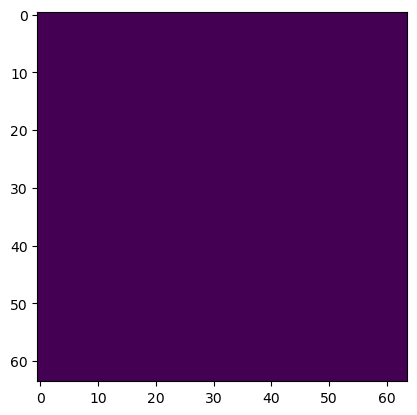

In [67]:
plt.imshow(fs[2])

In [63]:
fs[1]

array([[7.78134445e-06, 7.76558785e-06, 7.71552225e-06, ...,
        7.62404933e-06, 7.71552225e-06, 7.76558785e-06],
       [7.79596731e-06, 7.78640852e-06, 7.74184329e-06, ...,
        7.62179388e-06, 7.71804282e-06, 7.77391118e-06],
       [7.83908674e-06, 7.83564942e-06, 7.79631390e-06, ...,
        7.64703547e-06, 7.74860604e-06, 7.81060537e-06],
       ...,
       [7.90850952e-06, 7.87346664e-06, 7.80499945e-06, ...,
        7.79676926e-06, 7.87678177e-06, 7.91113206e-06],
       [7.83908674e-06, 7.81060537e-06, 7.74860604e-06, ...,
        7.71290688e-06, 7.79631390e-06, 7.83564942e-06],
       [7.79596731e-06, 7.77391118e-06, 7.71804282e-06, ...,
        7.65463440e-06, 7.74184329e-06, 7.78640852e-06]])

In [62]:
fs[2]

array([[-5.30304424e-06, -5.25079073e-06, -5.10240544e-06, ...,
        -4.86909620e-06, -5.10240544e-06, -5.25079073e-06],
       [-5.27547703e-06, -5.18277358e-06, -4.99665383e-06, ...,
        -4.95895585e-06, -5.15516155e-06, -5.26426693e-06],
       [-5.19308488e-06, -5.06107886e-06, -4.83922523e-06, ...,
        -4.99691600e-06, -5.15415869e-06, -5.22293838e-06],
       ...,
       [-5.05679968e-06, -5.12715318e-06, -5.09920570e-06, ...,
        -4.30263505e-06, -4.63198531e-06, -4.88716488e-06],
       [-5.19308488e-06, -5.22293838e-06, -5.15415869e-06, ...,
        -4.53899476e-06, -4.83922523e-06, -5.06107886e-06],
       [-5.27547703e-06, -5.26426693e-06, -5.15516155e-06, ...,
        -4.72854284e-06, -4.99665383e-06, -5.18277358e-06]])